In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [41]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [42]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [121]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [122]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [123]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
valid sample : 857 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0
test sample : 1072 	 24 MRO Services : 0.0 	 24 Workshop Equipment&Supplies : 0.0 	Industrial Gases : 0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [124]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [125]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [126]:
all_col = list(X_train.columns)

In [127]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [128]:
from keras.utils import to_categorical

# NN Model 

In [129]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 26, 20)            116640    
_________________________________________________________________
flatten_4 (Flatten)          (None, 520)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5210      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 33        
Total params: 121,883
Trainable params: 121,883
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [131]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9953
Testing Accuracy:  0.9963


In [132]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

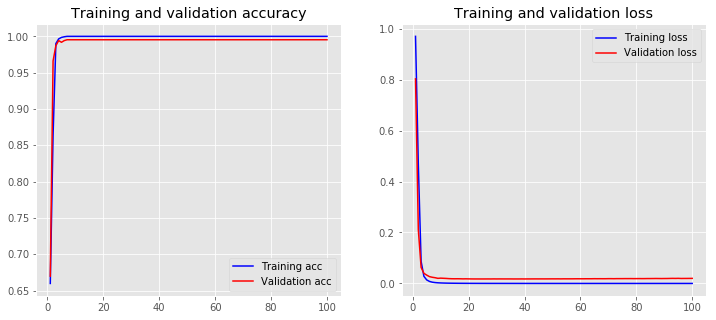

In [133]:
plot_history(history)

# Hyperparameter Tuning

In [134]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [179]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_dense=10):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense, activation=activation))
    model.add(layers.Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [141]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001],
          'embedding_dim' : [10,15,20,25,30],
          'n_dense' : [5,10,15,20]
         }

In [142]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [143]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [144]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
2284/2284 [==============================] - 1s 460us/step - loss: 0.9322 - accuracy: 0.6493
Epoch 2/10
2284/2284 [==============================] - 0s 196us/step - loss: 0.5968 - accuracy: 0.7754
Epoch 3/10
2284/2284 [==============================] - 1s 220us/step - loss: 0.2981 - accuracy: 0.9553
Epoch 4/10
2284/2284 [==============================] - 0s 192us/step - loss: 0.1733 - accuracy: 0.9899
Epoch 5/10
2284/2284 [==============================] - 0s 183us/step - loss: 0.1136 - accuracy: 0.9943
Epoch 6/10
2284/2284 [==============================] - 0s 193us/step - loss: 0.0788 - accuracy: 0.9965
Epoch 7/10
2284/2284 [==============================] - 0s 212us/step - loss: 0.0563 - accuracy: 0.9987
Epoch 8/10
2284/2284 [==============================] - 0s 205us/step - loss: 0.0425 - accuracy: 0.9996
Epoch 9/10
2284/2284 [==============================] - 0s 194us/step - loss: 0.0334 - accuracy: 1.0000
Epoch 10/10
2284/2284 [=====================

2285/2285 [==============================] - 1s 330us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 14/30
2285/2285 [==============================] - 1s 337us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 15/30
2285/2285 [==============================] - 1s 346us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 16/30
2285/2285 [==============================] - 1s 361us/step - loss: 9.9352e-04 - accuracy: 1.0000
Epoch 17/30
2285/2285 [==============================] - 1s 348us/step - loss: 8.7917e-04 - accuracy: 1.0000
Epoch 18/30
2285/2285 [==============================] - 1s 360us/step - loss: 7.8179e-04 - accuracy: 1.0000
Epoch 19/30
2285/2285 [==============================] - 1s 335us/step - loss: 6.9860e-04 - accuracy: 1.0000
Epoch 20/30
2285/2285 [==============================] - 1s 338us/step - loss: 6.2669e-04 - accuracy: 1.0000
Epoch 21/30
2285/2285 [==============================] - 1s 346us/step - loss: 5.6404e-04 - accuracy: 1.0000
Epoch 22/30
2285/2285 [====================

2285/2285 [==============================] - 1s 355us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 6/10
2285/2285 [==============================] - 1s 378us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 7/10
2285/2285 [==============================] - 1s 396us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 8/10
2285/2285 [==============================] - 1s 336us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/10
2285/2285 [==============================] - 1s 356us/step - loss: 8.1431e-04 - accuracy: 1.0000
Epoch 10/10
2285/2285 [==============================] - 0s 111us/step
Epoch 1/30
2284/2284 [==============================] - 1s 423us/step - loss: 0.9227 - accuracy: 0.6677
Epoch 2/30
2284/2284 [==============================] - 0s 103us/step - loss: 0.6290 - accuracy: 0.6852
Epoch 3/30
2284/2284 [==============================] - 0s 111us/step - loss: 0.3546 - accuracy: 0.8945
Epoch 4/30
2284/2284 [==============================] - 0s 119us/step - loss: 0.1186 - accuracy: 0.9917


2285/2285 [==============================] - 0s 120us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 9/30
2285/2285 [==============================] - 0s 115us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 10/30
2285/2285 [==============================] - 0s 113us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 11/30
2285/2285 [==============================] - 0s 104us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 12/30
2285/2285 [==============================] - 0s 105us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 13/30
2285/2285 [==============================] - 0s 103us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 14/30
2285/2285 [==============================] - 0s 120us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 15/30
2285/2285 [==============================] - 0s 119us/step - loss: 9.3435e-04 - accuracy: 1.0000
Epoch 16/30
2285/2285 [==============================] - 0s 113us/step - loss: 8.1263e-04 - accuracy: 1.0000
Epoch 17/30
2285/2285 [==============================] - 0s 

2285/2285 [==============================] - 0s 107us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 13/20
2285/2285 [==============================] - 0s 121us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 14/20
2285/2285 [==============================] - 0s 95us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 15/20
2285/2285 [==============================] - 0s 96us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 16/20
2285/2285 [==============================] - 0s 105us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 17/20
2285/2285 [==============================] - 0s 104us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 18/20
2285/2285 [==============================] - 0s 100us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 19/20
2285/2285 [==============================] - 0s 101us/step - loss: 9.3660e-04 - accuracy: 1.0000
Epoch 20/20
2285/2285 [==============================] - 0s 37us/step
Epoch 1/20
2284/2284 [==============================] - 1s 552us/step - loss: 0.8180 - accuracy: 0.6

2284/2284 [==============================] - 1s 387us/step - loss: 0.0112 - accuracy: 0.9996
Epoch 6/10
2284/2284 [==============================] - 1s 394us/step - loss: 0.0058 - accuracy: 0.9996
Epoch 7/10
2284/2284 [==============================] - 1s 368us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 8/10
2284/2284 [==============================] - 1s 368us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 9/10
2284/2284 [==============================] - 1s 413us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
2284/2284 [==============================] - 0s 156us/step
Epoch 1/10
2285/2285 [==============================] - 2s 892us/step - loss: 0.7875 - accuracy: 0.6989
Epoch 2/10
2285/2285 [==============================] - 1s 371us/step - loss: 0.2087 - accuracy: 0.9177
Epoch 3/10
2285/2285 [==============================] - 1s 417us/step - loss: 0.0417 - accuracy: 0.9969
Epoch 4/10
2285/2285 [==============================] - 1s 378us/step - loss: 0.0123 - accuracy: 0.9991
Epoc

2284/2284 [==============================] - 1s 430us/step - loss: 9.1881e-04 - accuracy: 1.0000
Epoch 17/30
2284/2284 [==============================] - 1s 453us/step - loss: 8.0750e-04 - accuracy: 1.0000
Epoch 18/30
2284/2284 [==============================] - 1s 448us/step - loss: 7.1397e-04 - accuracy: 1.0000
Epoch 19/30
2284/2284 [==============================] - 1s 438us/step - loss: 6.3430e-04 - accuracy: 1.0000
Epoch 20/30
2284/2284 [==============================] - 1s 431us/step - loss: 5.6614e-04 - accuracy: 1.0000
Epoch 21/30
2284/2284 [==============================] - 1s 452us/step - loss: 5.0709e-04 - accuracy: 1.0000
Epoch 22/30
2284/2284 [==============================] - 1s 447us/step - loss: 4.5608e-04 - accuracy: 1.0000
Epoch 23/30
2284/2284 [==============================] - 1s 439us/step - loss: 4.1132e-04 - accuracy: 1.0000
Epoch 24/30
2284/2284 [==============================] - 2s 788us/step - loss: 3.7189e-04 - accuracy: 1.0000
Epoch 25/30
2284/2284 [========

2285/2285 [==============================] - 0s 184us/step
Epoch 1/30
2284/2284 [==============================] - 1s 546us/step - loss: 1.0449 - accuracy: 0.6524
Epoch 2/30
2284/2284 [==============================] - 0s 130us/step - loss: 0.8999 - accuracy: 0.6769
Epoch 3/30
2284/2284 [==============================] - 0s 137us/step - loss: 0.7361 - accuracy: 0.6887
Epoch 4/30
2284/2284 [==============================] - 0s 122us/step - loss: 0.5303 - accuracy: 0.7653
Epoch 5/30
2284/2284 [==============================] - 0s 133us/step - loss: 0.3330 - accuracy: 0.8113
Epoch 6/30
2284/2284 [==============================] - 0s 135us/step - loss: 0.1631 - accuracy: 0.9882
Epoch 7/30
2284/2284 [==============================] - 0s 124us/step - loss: 0.0483 - accuracy: 0.9961
Epoch 8/30
2284/2284 [==============================] - 0s 127us/step - loss: 0.0140 - accuracy: 0.9996
Epoch 9/30
2284/2284 [==============================] - 0s 144us/step - loss: 0.0075 - accuracy: 1.0000
Epoch

2285/2285 [==============================] - 0s 142us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 15/30
2285/2285 [==============================] - 0s 134us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 16/30
2285/2285 [==============================] - 0s 129us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 17/30
2285/2285 [==============================] - 0s 124us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 18/30
2285/2285 [==============================] - 0s 184us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 19/30
2285/2285 [==============================] - 0s 145us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 20/30
2285/2285 [==============================] - 0s 146us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 21/30
2285/2285 [==============================] - 0s 118us/step - loss: 9.5661e-04 - accuracy: 1.0000
Epoch 22/30
2285/2285 [==============================] - 0s 124us/step - loss: 8.6192e-04 - accuracy: 1.0000
Epoch 23/30
2285/2285 [==============================] - 0s

2285/2285 [==============================] - 0s 121us/step - loss: 0.0227 - accuracy: 1.0000
Epoch 30/30
2285/2285 [==============================] - 0s 57us/step
Epoch 1/30
2285/2285 [==============================] - 1s 618us/step - loss: 0.9868 - accuracy: 0.6639
Epoch 2/30
2285/2285 [==============================] - 0s 142us/step - loss: 0.7299 - accuracy: 0.7685
Epoch 3/30
2285/2285 [==============================] - 0s 135us/step - loss: 0.4734 - accuracy: 0.8849
Epoch 4/30
2285/2285 [==============================] - 0s 164us/step - loss: 0.3262 - accuracy: 0.9580
Epoch 5/30
2285/2285 [==============================] - 0s 150us/step - loss: 0.2503 - accuracy: 0.9921
Epoch 6/30
2285/2285 [==============================] - 0s 159us/step - loss: 0.2036 - accuracy: 0.9969
Epoch 7/30
2285/2285 [==============================] - 0s 149us/step - loss: 0.1706 - accuracy: 0.9991
Epoch 8/30
2285/2285 [==============================] - 0s 159us/step - loss: 0.1455 - accuracy: 0.9991
Epoch

2285/2285 [==============================] - 0s 183us/step - loss: 0.1869 - accuracy: 0.9987
Epoch 14/30
2285/2285 [==============================] - 0s 178us/step - loss: 0.1728 - accuracy: 0.9991
Epoch 15/30
2285/2285 [==============================] - 0s 189us/step - loss: 0.1603 - accuracy: 0.9996
Epoch 16/30
2285/2285 [==============================] - 0s 190us/step - loss: 0.1492 - accuracy: 0.9996
Epoch 17/30
2285/2285 [==============================] - 0s 205us/step - loss: 0.1392 - accuracy: 1.0000
Epoch 18/30
2285/2285 [==============================] - 0s 197us/step - loss: 0.1300 - accuracy: 1.0000
Epoch 19/30
2285/2285 [==============================] - 1s 219us/step - loss: 0.1216 - accuracy: 1.0000
Epoch 20/30
2285/2285 [==============================] - 0s 146us/step - loss: 0.1138 - accuracy: 1.0000
Epoch 21/30
2285/2285 [==============================] - 0s 167us/step - loss: 0.1067 - accuracy: 1.0000
Epoch 22/30
2285/2285 [==============================] - 0s 200us/s

2285/2285 [==============================] - 0s 141us/step - loss: 0.0840 - accuracy: 0.9987
Epoch 7/10
2285/2285 [==============================] - 0s 172us/step - loss: 0.0604 - accuracy: 0.9987
Epoch 8/10
2285/2285 [==============================] - 0s 146us/step - loss: 0.0460 - accuracy: 0.9996
Epoch 9/10
2285/2285 [==============================] - 0s 136us/step - loss: 0.0366 - accuracy: 1.0000
Epoch 10/10
2285/2285 [==============================] - 0s 62us/step
Epoch 1/10
2284/2284 [==============================] - 2s 721us/step - loss: 0.8303 - accuracy: 0.6624
Epoch 2/10
2284/2284 [==============================] - 1s 286us/step - loss: 0.3039 - accuracy: 0.9282
Epoch 3/10
2284/2284 [==============================] - 1s 263us/step - loss: 0.0921 - accuracy: 0.9930
Epoch 4/10
2284/2284 [==============================] - 1s 304us/step - loss: 0.0423 - accuracy: 0.9978
Epoch 5/10
2284/2284 [==============================] - 1s 277us/step - loss: 0.0241 - accuracy: 0.9996
Epoch

2285/2285 [==============================] - 1s 505us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 19/20
2285/2285 [==============================] - 1s 533us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 20/20
2285/2285 [==============================] - 0s 192us/step
Epoch 1/20
2285/2285 [==============================] - 2s 1ms/step - loss: 0.6872 - accuracy: 0.7457
Epoch 2/20
2285/2285 [==============================] - 1s 591us/step - loss: 0.2266 - accuracy: 0.9829
Epoch 3/20
2285/2285 [==============================] - 1s 503us/step - loss: 0.0913 - accuracy: 0.9974
Epoch 4/20
2285/2285 [==============================] - 1s 562us/step - loss: 0.0483 - accuracy: 0.9987
Epoch 5/20
2285/2285 [==============================] - 1s 546us/step - loss: 0.0305 - accuracy: 0.9991
Epoch 6/20
2285/2285 [==============================] - 1s 543us/step - loss: 0.0210 - accuracy: 1.0000
Epoch 7/20
2285/2285 [==============================] - 1s 594us/step - loss: 0.0158 - accuracy: 1.0000
Epoch

2285/2285 [==============================] - 1s 221us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 12/20
2285/2285 [==============================] - 0s 178us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 13/20
2285/2285 [==============================] - 0s 184us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 14/20
2285/2285 [==============================] - 0s 185us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 15/20
2285/2285 [==============================] - 0s 127us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 16/20
2285/2285 [==============================] - 0s 137us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 17/20
2285/2285 [==============================] - 0s 137us/step - loss: 9.7753e-04 - accuracy: 1.0000
Epoch 18/20
2285/2285 [==============================] - 0s 146us/step - loss: 8.5235e-04 - accuracy: 1.0000
Epoch 19/20
2285/2285 [==============================] - 0s 140us/step - loss: 7.5037e-04 - accuracy: 1.0000
Epoch 20/20
2285/2285 [==============================] 

2284/2284 [==============================] - 1s 629us/step - loss: 0.0111 - accuracy: 0.9996
Epoch 5/20
2284/2284 [==============================] - 1s 632us/step - loss: 0.0062 - accuracy: 0.9996
Epoch 6/20
2284/2284 [==============================] - 2s 781us/step - loss: 0.0037 - accuracy: 0.9996
Epoch 7/20
2284/2284 [==============================] - 1s 541us/step - loss: 0.0024 - accuracy: 1.00000s - loss: 0.0
Epoch 8/20
2284/2284 [==============================] - 1s 489us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 9/20
2284/2284 [==============================] - 1s 473us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 10/20
2284/2284 [==============================] - 1s 508us/step - loss: 8.9125e-04 - accuracy: 1.0000
Epoch 11/20
2284/2284 [==============================] - 1s 497us/step - loss: 7.0612e-04 - accuracy: 1.0000
Epoch 12/20
2284/2284 [==============================] - 1s 513us/step - loss: 5.6646e-04 - accuracy: 1.0000
Epoch 13/20
2284/2284 [=======================

2284/2284 [==============================] - 1s 650us/step - loss: 3.8299e-04 - accuracy: 1.0000
Epoch 17/20
2284/2284 [==============================] - 1s 641us/step - loss: 3.2375e-04 - accuracy: 1.0000
Epoch 18/20
2284/2284 [==============================] - 2s 681us/step - loss: 2.8062e-04 - accuracy: 1.0000
Epoch 19/20
2284/2284 [==============================] - 2s 708us/step - loss: 2.4135e-04 - accuracy: 1.0000
Epoch 20/20
2284/2284 [==============================] - 1s 333us/step
Epoch 1/20
2285/2285 [==============================] - 3s 1ms/step - loss: 0.7902 - accuracy: 0.6770
Epoch 2/20
2285/2285 [==============================] - 2s 777us/step - loss: 0.3294 - accuracy: 0.89850s - loss: 0.3518 - 
Epoch 3/20
2285/2285 [==============================] - 2s 853us/step - loss: 0.0749 - accuracy: 0.9961
Epoch 4/20
2285/2285 [==============================] - 2s 773us/step - loss: 0.0132 - accuracy: 0.9991
Epoch 5/20
2285/2285 [==============================] - 2s 782us/step -

2285/2285 [==============================] - 1s 390us/step - loss: 0.0266 - accuracy: 0.9991
Epoch 8/10
2285/2285 [==============================] - 1s 415us/step - loss: 0.0198 - accuracy: 0.9991
Epoch 9/10
2285/2285 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.99 - 1s 364us/step - loss: 0.0147 - accuracy: 0.9996
Epoch 10/10
2285/2285 [==============================] - 1s 386us/step
Epoch 1/30
3427/3427 [==============================] - 3s 908us/step - loss: 0.5370 - accuracy: 0.8095
Epoch 2/30
3427/3427 [==============================] - 1s 236us/step - loss: 0.0632 - accuracy: 0.9939
Epoch 3/30
3427/3427 [==============================] - 1s 237us/step - loss: 0.0177 - accuracy: 0.9988
Epoch 4/30
3427/3427 [==============================] - 1s 236us/step - loss: 0.0082 - accuracy: 0.9997
Epoch 5/30
3427/3427 [==============================] - 2s 473us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 6/30
3427/3427 [==============================] - 4s 1ms/ste

In [146]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.013907503544339598 and Best Params:  {'n_dense': 20, 'learning_rate': 0.01, 'epochs': 30, 'embedding_dim': 20, 'batch_size': 16, 'activation': 'tanh'}


## Fit Best Model

In [180]:
model = create_model(learning_rate=0.01, activation='tanh', embedding_dim=20, n_dense=20)

In [181]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=16)

In [182]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9930
Testing Accuracy:  0.9972


In [185]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

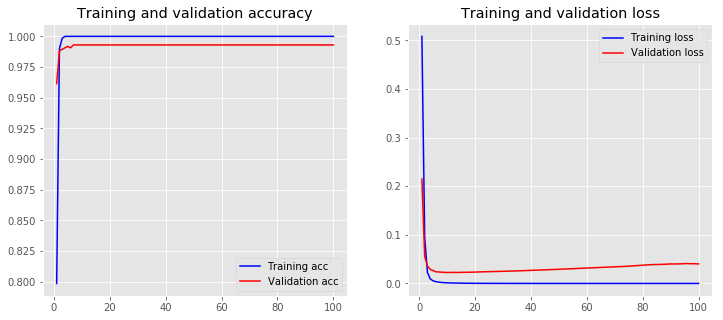

In [186]:
plot_history(history)

# Model Evaluation: Test Data

In [187]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9972015023231506


Confusion matrix, without normalization


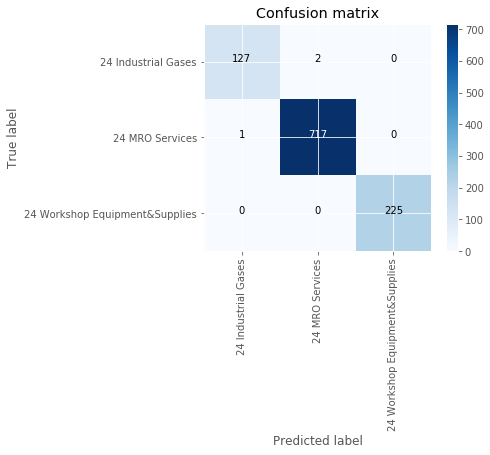

In [188]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [189]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9943160629545514

In [190]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,0.992188,0.984496,0.988327,129
1,24 MRO Services,0.997218,0.998607,0.997912,718
2,24 Workshop Equipment&Supplies,1.000000,1.000000,1.000000,225


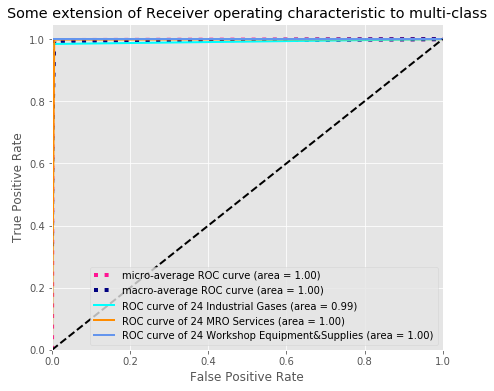

In [191]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [192]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

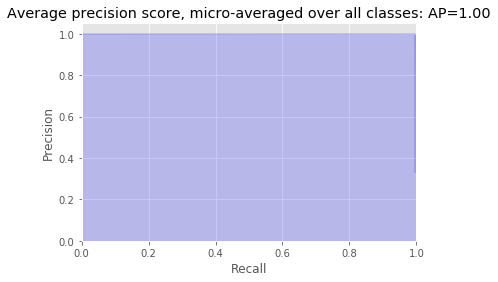

In [193]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

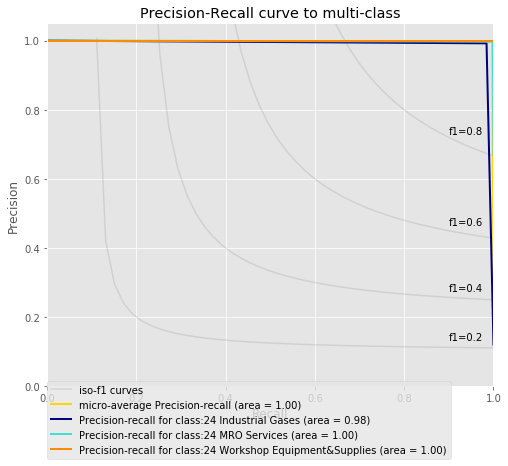

In [194]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()

# Trying globalmaxpool1D layer after enbedding

In [161]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 26, 20)            116640    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_134 (Dense)            (None, 3)                 33        
Total params: 116,883
Trainable params: 116,883
Non-trainable params: 0
_________________________________________________________________


In [162]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [163]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9942
Testing Accuracy:  0.9991


In [164]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

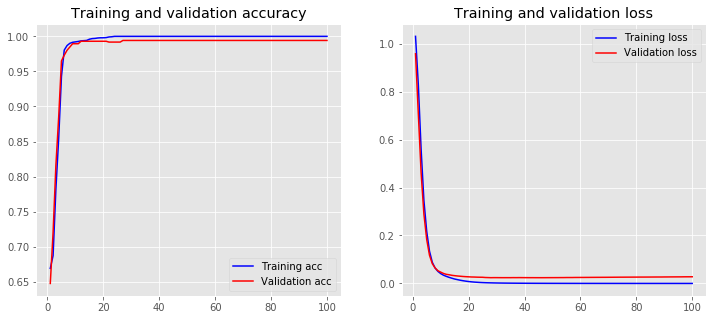

In [165]:
plot_history(history)

# Hyperparameter Tuning

In [134]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [195]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_dense=10):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(n_dense, activation=activation))
    model.add(layers.Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [167]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001],
          'embedding_dim' : [10,15,20,25,30],
          'n_dense' : [5,10,15,20]
         }

In [168]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [169]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [170]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
2284/2284 [==============================] - 2s 862us/step - loss: 1.0178 - accuracy: 0.6313
Epoch 2/10
2284/2284 [==============================] - 1s 229us/step - loss: 0.7852 - accuracy: 0.6694
Epoch 3/10
2284/2284 [==============================] - 1s 231us/step - loss: 0.5965 - accuracy: 0.6743
Epoch 4/10
2284/2284 [==============================] - 1s 223us/step - loss: 0.4469 - accuracy: 0.8271
Epoch 5/10
2284/2284 [==============================] - 1s 220us/step - loss: 0.3311 - accuracy: 0.9387
Epoch 6/10
2284/2284 [==============================] - 1s 219us/step - loss: 0.2430 - accuracy: 0.9750
Epoch 7/10
2284/2284 [==============================] - 0s 210us/step - loss: 0.1673 - accuracy: 0.9899
Epoch 8/10
2284/2284 [==============================] - 1s 229us/step - loss: 0.1128 - accuracy: 0.9939
Epoch 9/10
2284/2284 [==============================] - 1s 250us/step - loss: 0.0795 - accuracy: 0.9956
Epoch 10/10
2284/2284 [=====================

2285/2285 [==============================] - 1s 549us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 15/30
2285/2285 [==============================] - 1s 575us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 16/30
2285/2285 [==============================] - 1s 538us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 17/30
2285/2285 [==============================] - 1s 458us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 18/30
2285/2285 [==============================] - 1s 494us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 19/30
2285/2285 [==============================] - 1s 486us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 20/30
2285/2285 [==============================] - 1s 483us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 21/30
2285/2285 [==============================] - 1s 561us/step - loss: 9.2837e-04 - accuracy: 1.0000
Epoch 22/30
2285/2285 [==============================] - 1s 489us/step - loss: 8.2478e-04 - accuracy: 1.0000
Epoch 23/30
2285/2285 [==============================] - 1s

2285/2285 [==============================] - 1s 522us/step - loss: 0.0346 - accuracy: 0.9926
Epoch 8/10
2285/2285 [==============================] - 1s 576us/step - loss: 0.0244 - accuracy: 0.9952
Epoch 9/10
2285/2285 [==============================] - 1s 571us/step - loss: 0.0183 - accuracy: 0.9969
Epoch 10/10
2285/2285 [==============================] - 0s 190us/step
Epoch 1/30
2284/2284 [==============================] - 2s 912us/step - loss: 1.0695 - accuracy: 0.5937
Epoch 2/30
2284/2284 [==============================] - 0s 167us/step - loss: 0.9808 - accuracy: 0.6694
Epoch 3/30
2284/2284 [==============================] - 0s 172us/step - loss: 0.8333 - accuracy: 0.6966
Epoch 4/30
2284/2284 [==============================] - 0s 167us/step - loss: 0.6239 - accuracy: 0.7824
Epoch 5/30
2284/2284 [==============================] - 0s 152us/step - loss: 0.4292 - accuracy: 0.8336
Epoch 6/30
2284/2284 [==============================] - 0s 153us/step - loss: 0.3001 - accuracy: 0.8647
Epoc

2285/2285 [==============================] - 0s 160us/step - loss: 0.0234 - accuracy: 0.9969
Epoch 13/30
2285/2285 [==============================] - 0s 171us/step - loss: 0.0185 - accuracy: 0.9978
Epoch 14/30
2285/2285 [==============================] - 0s 163us/step - loss: 0.0150 - accuracy: 0.9982
Epoch 15/30
2285/2285 [==============================] - 0s 150us/step - loss: 0.0124 - accuracy: 0.9982
Epoch 16/30
2285/2285 [==============================] - 0s 161us/step - loss: 0.0105 - accuracy: 0.9987
Epoch 17/30
2285/2285 [==============================] - 0s 159us/step - loss: 0.0088 - accuracy: 0.9987
Epoch 18/30
2285/2285 [==============================] - 0s 151us/step - loss: 0.0075 - accuracy: 0.9987
Epoch 19/30
2285/2285 [==============================] - 0s 157us/step - loss: 0.0063 - accuracy: 0.9987
Epoch 20/30
2285/2285 [==============================] - 0s 157us/step - loss: 0.0053 - accuracy: 0.9987
Epoch 21/30
2285/2285 [==============================] - 0s 153us/s

2285/2285 [==============================] - 0s 142us/step - loss: 0.0182 - accuracy: 0.9969
Epoch 18/20
2285/2285 [==============================] - 0s 152us/step - loss: 0.0156 - accuracy: 0.9982
Epoch 19/20
2285/2285 [==============================] - 0s 166us/step - loss: 0.0134 - accuracy: 0.9982
Epoch 20/20
2285/2285 [==============================] - 0s 57us/step
Epoch 1/20
2284/2284 [==============================] - 3s 1ms/step - loss: 0.9441 - accuracy: 0.6546
Epoch 2/20
2284/2284 [==============================] - 1s 585us/step - loss: 0.6270 - accuracy: 0.7609
Epoch 3/20
2284/2284 [==============================] - 1s 597us/step - loss: 0.4101 - accuracy: 0.8949
Epoch 4/20
2284/2284 [==============================] - 1s 514us/step - loss: 0.2936 - accuracy: 0.9588
Epoch 5/20
2284/2284 [==============================] - 1s 508us/step - loss: 0.2163 - accuracy: 0.9742
Epoch 6/20
2284/2284 [==============================] - 1s 540us/step - loss: 0.1616 - accuracy: 0.9886
Epoch

2284/2284 [==============================] - 1s 228us/step
Epoch 1/10
2285/2285 [==============================] - 3s 1ms/step - loss: 1.0053 - accuracy: 0.6398
Epoch 2/10
2285/2285 [==============================] - 1s 414us/step - loss: 0.6231 - accuracy: 0.6932
Epoch 3/10
2285/2285 [==============================] - 1s 450us/step - loss: 0.3388 - accuracy: 0.8468
Epoch 4/10
2285/2285 [==============================] - 1s 416us/step - loss: 0.1857 - accuracy: 0.9475
Epoch 5/10
2285/2285 [==============================] - 1s 414us/step - loss: 0.1096 - accuracy: 0.9812
Epoch 6/10
2285/2285 [==============================] - 1s 437us/step - loss: 0.0683 - accuracy: 0.9860
Epoch 7/10
2285/2285 [==============================] - 1s 422us/step - loss: 0.0470 - accuracy: 0.9895
Epoch 8/10
2285/2285 [==============================] - 1s 423us/step - loss: 0.0347 - accuracy: 0.9921
Epoch 9/10
2285/2285 [==============================] - 1s 424us/step - loss: 0.0268 - accuracy: 0.9926
Epoch 1

2284/2284 [==============================] - 1s 544us/step - loss: 9.1986e-04 - accuracy: 1.0000
Epoch 24/30
2284/2284 [==============================] - 1s 562us/step - loss: 8.2107e-04 - accuracy: 1.0000
Epoch 25/30
2284/2284 [==============================] - 1s 548us/step - loss: 7.3501e-04 - accuracy: 1.0000
Epoch 26/30
2284/2284 [==============================] - 1s 538us/step - loss: 6.6002e-04 - accuracy: 1.0000
Epoch 27/30
2284/2284 [==============================] - 1s 562us/step - loss: 5.9327e-04 - accuracy: 1.0000
Epoch 28/30
2284/2284 [==============================] - 1s 567us/step - loss: 5.3559e-04 - accuracy: 1.0000
Epoch 29/30
2284/2284 [==============================] - 1s 635us/step - loss: 4.8463e-04 - accuracy: 1.0000
Epoch 30/30
2284/2284 [==============================] - 1s 235us/step
Epoch 1/30
2285/2285 [==============================] - 3s 1ms/step - loss: 0.8043 - accuracy: 0.6722
Epoch 2/30
2285/2285 [==============================] - 1s 556us/step - loss

2284/2284 [==============================] - 0s 153us/step - loss: 0.5166 - accuracy: 0.6694
Epoch 7/30
2284/2284 [==============================] - 0s 153us/step - loss: 0.4112 - accuracy: 0.7596
Epoch 8/30
2284/2284 [==============================] - 0s 148us/step - loss: 0.3059 - accuracy: 0.9335
Epoch 9/30
2284/2284 [==============================] - 0s 157us/step - loss: 0.1992 - accuracy: 0.9812
Epoch 10/30
2284/2284 [==============================] - 0s 160us/step - loss: 0.1295 - accuracy: 0.9877
Epoch 11/30
2284/2284 [==============================] - 0s 150us/step - loss: 0.0908 - accuracy: 0.9921
Epoch 12/30
2284/2284 [==============================] - 0s 158us/step - loss: 0.0677 - accuracy: 0.9934
Epoch 13/30
2284/2284 [==============================] - 0s 152us/step - loss: 0.0524 - accuracy: 0.9943
Epoch 14/30
2284/2284 [==============================] - 0s 160us/step - loss: 0.0423 - accuracy: 0.9956
Epoch 15/30
2284/2284 [==============================] - 0s 151us/step

2285/2285 [==============================] - 0s 156us/step - loss: 0.0092 - accuracy: 0.9996
Epoch 23/30
2285/2285 [==============================] - 0s 159us/step - loss: 0.0081 - accuracy: 0.9996
Epoch 24/30
2285/2285 [==============================] - 0s 165us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 25/30
2285/2285 [==============================] - 0s 148us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 26/30
2285/2285 [==============================] - 0s 156us/step - loss: 0.0056 - accuracy: 1.0000
Epoch 27/30
2285/2285 [==============================] - 0s 156us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 28/30
2285/2285 [==============================] - 0s 154us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 29/30
2285/2285 [==============================] - 0s 162us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 30/30
2285/2285 [==============================] - 0s 79us/step
Epoch 1/30
2284/2284 [==============================] - 3s 1ms/step - loss: 1.0282 - accuracy: 0.6353


2285/2285 [==============================] - 1s 277us/step - loss: 0.3659 - accuracy: 0.9532
Epoch 8/30
2285/2285 [==============================] - 1s 269us/step - loss: 0.3199 - accuracy: 0.9676
Epoch 9/30
2285/2285 [==============================] - 1s 278us/step - loss: 0.2866 - accuracy: 0.9737
Epoch 10/30
2285/2285 [==============================] - 1s 266us/step - loss: 0.2591 - accuracy: 0.9759
Epoch 11/30
2285/2285 [==============================] - 1s 269us/step - loss: 0.2342 - accuracy: 0.9790
Epoch 12/30
2285/2285 [==============================] - 1s 266us/step - loss: 0.2107 - accuracy: 0.9799
Epoch 13/30
2285/2285 [==============================] - 1s 280us/step - loss: 0.1882 - accuracy: 0.9825
Epoch 14/30
2285/2285 [==============================] - 1s 270us/step - loss: 0.1673 - accuracy: 0.9851
Epoch 15/30
2285/2285 [==============================] - 1s 288us/step - loss: 0.1481 - accuracy: 0.9873
Epoch 16/30
2285/2285 [==============================] - 1s 273us/ste

2285/2285 [==============================] - 0s 182us/step - loss: 0.1228 - accuracy: 0.9943
Epoch 23/30
2285/2285 [==============================] - 0s 181us/step - loss: 0.1148 - accuracy: 0.9947
Epoch 24/30
2285/2285 [==============================] - 0s 169us/step - loss: 0.1075 - accuracy: 0.9952
Epoch 25/30
2285/2285 [==============================] - 0s 161us/step - loss: 0.1009 - accuracy: 0.9956
Epoch 26/30
2285/2285 [==============================] - 0s 164us/step - loss: 0.0950 - accuracy: 0.9961
Epoch 27/30
2285/2285 [==============================] - 0s 167us/step - loss: 0.0895 - accuracy: 0.9974
Epoch 28/30
2285/2285 [==============================] - 0s 159us/step - loss: 0.0845 - accuracy: 0.9978
Epoch 29/30
2285/2285 [==============================] - 0s 156us/step - loss: 0.0799 - accuracy: 0.9987
Epoch 30/30
2285/2285 [==============================] - 0s 71us/step
Epoch 1/30
2285/2285 [==============================] - 2s 1ms/step - loss: 1.0754 - accuracy: 0.6083


2284/2284 [==============================] - 1s 350us/step - loss: 0.3124 - accuracy: 0.8805
Epoch 5/10
2284/2284 [==============================] - 1s 343us/step - loss: 0.2067 - accuracy: 0.9444
Epoch 6/10
2284/2284 [==============================] - 1s 425us/step - loss: 0.1355 - accuracy: 0.9847
Epoch 7/10
2284/2284 [==============================] - 1s 391us/step - loss: 0.0860 - accuracy: 0.9908
Epoch 8/10
2284/2284 [==============================] - 1s 356us/step - loss: 0.0574 - accuracy: 0.99390s - los
Epoch 9/10
2284/2284 [==============================] - 1s 372us/step - loss: 0.0413 - accuracy: 0.9961
Epoch 10/10
2284/2284 [==============================] - 0s 142us/step
Epoch 1/10
2285/2285 [==============================] - 5s 2ms/step - loss: 0.9810 - accuracy: 0.6403
Epoch 2/10
2285/2285 [==============================] - 1s 433us/step - loss: 0.6630 - accuracy: 0.6722
Epoch 3/10
2285/2285 [==============================] - 1s 410us/step - loss: 0.4201 - accuracy: 0.799

2285/2285 [==============================] - 1s 649us/step - loss: 0.1280 - accuracy: 0.8862
Epoch 7/20
2285/2285 [==============================] - 1s 647us/step - loss: 0.1146 - accuracy: 0.9094
Epoch 8/20
2285/2285 [==============================] - 2s 718us/step - loss: 0.1064 - accuracy: 0.9339
Epoch 9/20
2285/2285 [==============================] - 2s 733us/step - loss: 0.1006 - accuracy: 0.9523
Epoch 10/20
2285/2285 [==============================] - 1s 643us/step - loss: 0.0960 - accuracy: 0.9694
Epoch 11/20
2285/2285 [==============================] - 1s 651us/step - loss: 0.0892 - accuracy: 0.9834
Epoch 12/20
2285/2285 [==============================] - 1s 649us/step - loss: 0.0559 - accuracy: 0.9978
Epoch 13/20
2285/2285 [==============================] - 1s 634us/step - loss: 0.0259 - accuracy: 0.9996
Epoch 14/20
2285/2285 [==============================] - 1s 646us/step - loss: 0.0144 - accuracy: 1.0000
Epoch 15/20
2285/2285 [==============================] - 1s 625us/step

2285/2285 [==============================] - 0s 87us/step
Epoch 1/20
2284/2284 [==============================] - 3s 1ms/step - loss: 0.9413 - accuracy: 0.6694
Epoch 2/20
2284/2284 [==============================] - 1s 353us/step - loss: 0.6763 - accuracy: 0.6694
Epoch 3/20
2284/2284 [==============================] - 1s 401us/step - loss: 0.5038 - accuracy: 0.7080
Epoch 4/20
2284/2284 [==============================] - 1s 397us/step - loss: 0.3595 - accuracy: 0.8402
Epoch 5/20
2284/2284 [==============================] - 1s 377us/step - loss: 0.2577 - accuracy: 0.8783
Epoch 6/20
2284/2284 [==============================] - 1s 366us/step - loss: 0.1900 - accuracy: 0.8954
Epoch 7/20
2284/2284 [==============================] - 1s 392us/step - loss: 0.1452 - accuracy: 0.9623
Epoch 8/20
2284/2284 [==============================] - 1s 392us/step - loss: 0.0951 - accuracy: 0.9834
Epoch 9/20
2284/2284 [==============================] - 1s 358us/step - loss: 0.0591 - accuracy: 0.9939
Epoch 10

Epoch 14/20
2284/2284 [==============================] - 1s 571us/step - loss: 0.0269 - accuracy: 0.9930
Epoch 15/20
2284/2284 [==============================] - 1s 625us/step - loss: 0.0249 - accuracy: 0.9947
Epoch 16/20
2284/2284 [==============================] - 1s 597us/step - loss: 0.0230 - accuracy: 0.9952
Epoch 17/20
2284/2284 [==============================] - 1s 524us/step - loss: 0.0211 - accuracy: 0.9952
Epoch 18/20
2284/2284 [==============================] - 1s 517us/step - loss: 0.0191 - accuracy: 0.9965
Epoch 19/20
2284/2284 [==============================] - 1s 523us/step - loss: 0.0180 - accuracy: 0.9961
Epoch 20/20
2284/2284 [==============================] - 1s 276us/step
Epoch 1/20
2285/2285 [==============================] - 4s 2ms/step - loss: 1.0068 - accuracy: 0.6490
Epoch 2/20
2285/2285 [==============================] - 1s 539us/step - loss: 0.6633 - accuracy: 0.6783
Epoch 3/20
2285/2285 [==============================] - 1s 529us/step - loss: 0.3669 - accura

2285/2285 [==============================] - 1s 653us/step - loss: 0.0424 - accuracy: 0.9961
Epoch 8/20
2285/2285 [==============================] - 2s 678us/step - loss: 0.0257 - accuracy: 0.9961
Epoch 9/20
2285/2285 [==============================] - 1s 649us/step - loss: 0.0174 - accuracy: 0.9978
Epoch 10/20
2285/2285 [==============================] - 1s 652us/step - loss: 0.0129 - accuracy: 0.9982
Epoch 11/20
2285/2285 [==============================] - 1s 652us/step - loss: 0.0096 - accuracy: 0.9987
Epoch 12/20
2285/2285 [==============================] - 2s 746us/step - loss: 0.0073 - accuracy: 0.9991
Epoch 13/20
2285/2285 [==============================] - 2s 690us/step - loss: 0.0059 - accuracy: 0.9996
Epoch 14/20
2285/2285 [==============================] - 2s 665us/step - loss: 0.0046 - accuracy: 0.9996
Epoch 15/20
2285/2285 [==============================] - 2s 659us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 16/20
2285/2285 [==============================] - 1s 646us/ste

3427/3427 [==============================] - 2s 692us/step - loss: 0.0052 - accuracy: 0.9997
Epoch 10/30
3427/3427 [==============================] - 2s 703us/step - loss: 0.0038 - accuracy: 0.9997
Epoch 11/30
3427/3427 [==============================] - 3s 795us/step - loss: 0.0028 - accuracy: 0.9997
Epoch 12/30
3427/3427 [==============================] - 2s 686us/step - loss: 0.0021 - accuracy: 1.00000s
Epoch 13/30
3427/3427 [==============================] - 2s 685us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 14/30
3427/3427 [==============================] - 2s 685us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 15/30
3427/3427 [==============================] - 2s 692us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 16/30
3427/3427 [==============================] - 2s 705us/step - loss: 9.0845e-04 - accuracy: 1.0000
Epoch 17/30
3427/3427 [==============================] - 2s 714us/step - loss: 7.6007e-04 - accuracy: 1.0000
Epoch 18/30
3427/3427 [==============================] - 

In [171]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.015070930754382074 and Best Params:  {'n_dense': 20, 'learning_rate': 0.01, 'epochs': 30, 'embedding_dim': 25, 'batch_size': 16, 'activation': 'tanh'}


## Fit Best Model

In [196]:
model = create_model(learning_rate=0.01, activation='tanh', embedding_dim=25, n_dense=20)

In [197]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=16)

In [198]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9953
Testing Accuracy:  0.9963


In [199]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

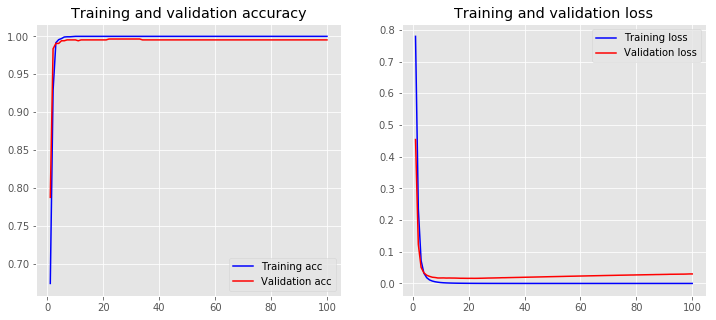

In [200]:
plot_history(history)

# Model Evaluation: Test Data

In [201]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.996268630027771


Confusion matrix, without normalization


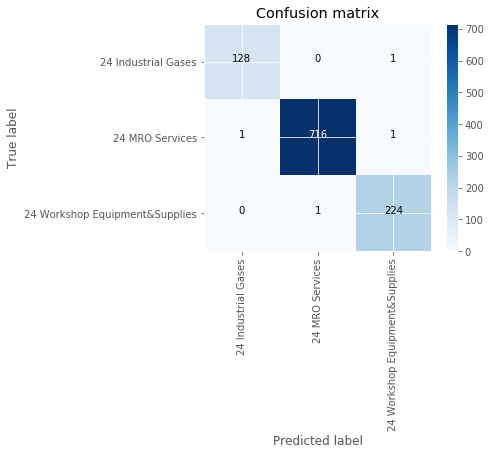

In [202]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [203]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9924358822834181

In [204]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,0.992248,0.992248,0.992248,129
1,24 MRO Services,0.998605,0.997214,0.997909,718
2,24 Workshop Equipment&Supplies,0.991150,0.995556,0.993348,225


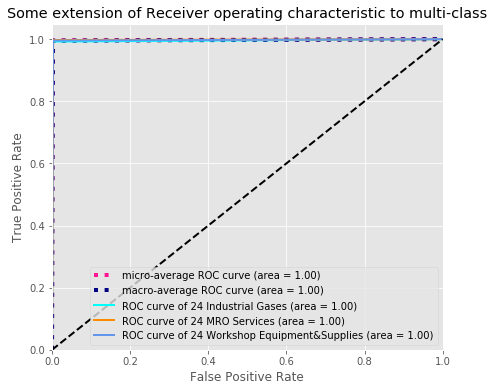

In [205]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [206]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

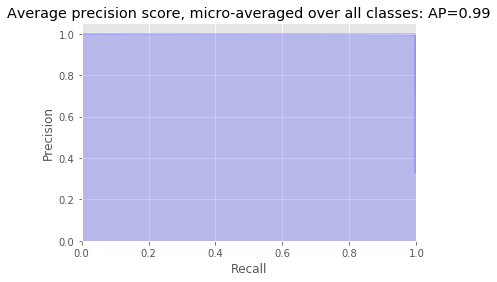

In [207]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

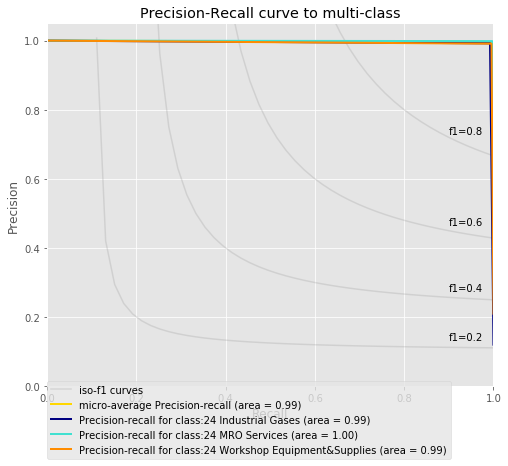

In [208]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()